# Word2Vec with BiLSTM
This time we'll do word prediction using word2vec approach 
## Data
Data is taken form recent Kaggle Toxic comment competition. Fields of CSV file are
<ul>
    <li>Source Address (IP/url or Ethernet/Physical)</li>
    <li> Comment</li>
</ul>
In addition in training file one hot encoding of classification type, total 6 types: 
<ul>
    <li>"toxic",</li>
    <li>"severe_toxic",</li>
    <li>"obscene", </li>
    <li>"threat",</li>
    <li>"insult",</li>
    <li>"identity_hate"</li>
</ul>
One hot means that to every type correspond a field (column) of the input and each comment/row has 1 in one of these fields (i.e. in the filed corresponding to the type associated to it) and 0 in all others.
Packages are same as before
# Preprocessing 
Exactly the same as before

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from nltk.tokenize import WordPunctTokenizer

In [2]:
from collections import Counter
from string import punctuation, ascii_lowercase
import regex as re
from tqdm import tqdm

In [3]:
try:
    from google.colab import drive
    IN_COLAB=True
except:
    IN_COLAB=False

In [4]:
if not IN_COLAB:
#    dir_path = os.path.dirname(os.path.realpath(os.getcwd()))
    dir_path = os.getcwd()
    data_dir = os.path.join(dir_path, 'Data/ToxicComment')
else:
    drive.mount('/content/gdrive')
    dir_path = os.path.dirname(os.path.realpath(os.path.abspath('')))
    data_dir = os.path.join(dir_path, '/content/gdrive/My Drive/courses/Deep Learning/data/ToxicComment')
if not os.path.exists(data_dir):
    exit(3)
else:
    TRAIN_DATA_FILE=os.path.join(data_dir,'train.csv')
    TEST_DATA_FILE=os.path.join(data_dir,'test.csv')
    train_df = pd.read_csv(TRAIN_DATA_FILE)
    test_df = pd.read_csv(TEST_DATA_FILE)
    print(train_df.head(10))

                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   
5  00025465d4725e87  "\n\nCongratulations from me as well, use the ...      0   
6  0002bcb3da6cb337       COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK      1   
7  00031b1e95af7921  Your vandalism to the Matt Shirvington article...      0   
8  00037261f536c51d  Sorry if the word 'nonsense' was offensive to ...      0   
9  00040093b2687caa  alignment on this subject and which are contra...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0          

In [5]:
re_url = re.compile(r"((http|https)\:\/\/)?[a-zA-Z0-9\.\/\?\:@\-_=#]+\
                    .([a-zA-Z]){2,6}([a-zA-Z0-9\.\&\/\?\:@\-_=#])*",
                    re.MULTILINE | re.UNICODE)
re_ip = re.compile("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}")

In [6]:
tokenizer = WordPunctTokenizer()
vocab = Counter()

In [7]:
def text_to_wordlist(text, lower=False):
    text = re_url.sub("URL", text)
    text = re_ip.sub("IPADDRESS", text)
    text = tokenizer.tokenize(text)
    if lower:
        text = [t.lower() for t in text]
    vocab.update(text)
    return text

In [8]:
def process_comments(list_sentences, lower=False):
    comments = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text, lower=lower)
        comments.append(txt)
    return comments

In [9]:
list_sentences_train = list(train_df["comment_text"].fillna("NAN_WORD").values)
list_sentences_test = list(test_df["comment_text"].fillna("NAN_WORD").values)

comments = process_comments(list_sentences_train + list_sentences_test, lower=True)
print("The vocabulary contains {} unique tokens".format(len(vocab)))

100%|███████████████████████████████████████████████████████████████████████| 312735/312735 [00:15<00:00, 19689.06it/s]

The vocabulary contains 365516 unique tokens


In [10]:
from gensim.models import Word2Vec
model = Word2Vec(comments, size=100, window=5, min_count=5, workers=16, sg=1, negative=5)
word_vectors = model.wv
print("Number of word vectors: {}".format(len(word_vectors.vocab)))
print(model.wv.most_similar_cosmul(positive=['woman', 'king'], negative=['man']))

Number of word vectors: 70056
[('hrh', 0.9356023073196411), ('dowager', 0.9251927733421326), ('duchess', 0.8999292254447937), ('aragon', 0.8964951038360596), ('castile', 0.891697883605957), ('regent', 0.8903980851173401), ('rightful', 0.8897174000740051), ('eldest', 0.8883494734764099), ('dukes', 0.8880857825279236), ('elizabeth', 0.8877835869789124)]


In [11]:
MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = 200

from keras.preprocessing.sequence import pad_sequences

word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}
sequences = [[word_index.get(t, 0) for t in comment]
             for comment in comments[:len(list_sentences_train)]]
test_sequences = [[word_index.get(t, 0)  for t in comment]
                  for comment in comments[len(list_sentences_train):]]

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH,
                     padding="pre", truncating="post")

Using TensorFlow backend.


In [12]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_df[list_classes].values
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (159571, 200)
Shape of label tensor: (159571, 6)


In [13]:
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="pre",
                          truncating="post")
print('Shape of test_data tensor:', test_data.shape)

Shape of test_data tensor: (153164, 200)


In [14]:
WV_DIM = 100
nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab))+1
print(nb_words)
wv_matrix = (np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0

70057


In [15]:
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        wv_matrix[i] = embedding_vector
    except:
        pass

In [17]:
from keras.layers import Embedding
wv_layer = Embedding(nb_words,
                     WV_DIM,
                     mask_zero=False,
                     weights=[wv_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False)

## New Paradigm of Model Creation
New paradigm in compiling model: we can call layers as functions. Conceptually: <br>
 <b> x=layer(input_shape)</b><br>
where for input_shape defines placeholder for compilation of what data type of the input layer is accepted. Model in this paradigm assembles layers into the model<br>
<em>Example:</em>
<p>
&nbsp;&nbsp;&nbsp;&nbsp; x= Input(shape=(32,))<br> 
&nbsp;&nbsp;&nbsp;&nbsp; y = Dense(16, activation='softmax')(x)<br>
&nbsp;&nbsp;&nbsp;&nbsp; model = Model(x, y)<br>
</p>
Here Input is called with specific shape and then y takes its output. When Model is given input layer and output layer the chain of input/outputs is assembled into a model<br>

### Layers in the Model
As we can see embedding is done with embedding layer aas before. Next we import Keras.layers. 
<ul>
    <li>The layer Input produces input object, i.e. it produces placeholder of a given shape. If we want to take a given type for the first layer we can specify it this way instead of inside the first layer definition. We can also specify wrapper here, e.g.
        <ul>
            <li>We could reshape data frame into  numpy array without doing it explicitly</li>  
            <li>We could specify specific conversion of data type without reshaping, as for example instead of a list of unsigned integers convert it to list of integer31</li>
        </ul>
    </li>
    <li>Dropout layer: instead of dropout specified inside a layer in the model it can be specified as a specific layer in which case it randomly sets input units to 0 with a frequency of rate $r$ at each step during training time. Inputs not set to 0 are scaled up by $1/(1 - r)$ such that the sum over all inputs is unchanged. Input to this layer is any tensor that is output of previous layer</li>
    <li>Layer SpatialDropout1D does the dropout of some elements of feature maps (neurons) altogether not just their random output connections. This only applies to RNN layers as tensor inputs are of the form (samples, timesteps, channels) </li>
    <li> Bidirectional layer: it consists of using two regular RNNs based on LSTM layers (see both imported) each of which processes the input sequence in one direction (chronologically and anti-chronologically), and then merging their representations.<br>
 &nbsp;&nbsp;&nbsp;&nbsp; - By processing a sequence both ways, a bidirectional RNN can catch patterns that may be overlooked by a unidirectional RNN<br></li>
    <li> Batch Normalization Layer: performs normalization during training by calculating the mean and standard deviation of each input variable to a layer per mini-batch and using these statistics to perform the standardization $\hat{x}=\frac{x-\mu}{\sigma}$ for each variable in each instance in the batch. Here $\mu$ is the mean of the variable over the bacth and $\sigma$ is its standard deviation compute over the batch.it is applied before calling dense layer</li>   
    </ul>

In [18]:
from keras.layers import Dense, Input, LSTM, Dropout,SpatialDropout1D, Bidirectional
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers import Embedding

In [19]:
comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = wv_layer(comment_input)

# biLSTM
embedded_sequences = SpatialDropout1D(0.2)(embedded_sequences)
x = Bidirectional(LSTM(64, return_sequences=False))(embedded_sequences)

# Output
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
preds = Dense(6, activation='sigmoid')(x)

We put together the model  and compile it using backproagation computed by adam method. Adam is different to classical stochastic gradient descent: stochastic gradient descent maintains a single learning rate (alpha) for all weight updates and the learning rate does not change during training. In adam the learning rate is maintained for each network weight (parameter) and separately adapted as learning unfolds. The method computes individual adaptive learning rates for different parameters from estimates of first and second moments of the gradients. Adam calculates an exponential moving average of the gradient and the squared gradient, and the parameters beta1 and beta2 control the decay rates of these moving averages.

In [20]:
model = Model(inputs=[comment_input], outputs=preds)
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001, clipnorm=.25, beta_1=0.7, beta_2=0.99),
              metrics=[])

Lastly fit the model and plot the results as usual.

Train on 143613 samples, validate on 15958 samples
Epoch 1/10
143613/143613 [==============================] - 904s 6ms/step - loss: 0.1707 - val_loss: 0.0555
Epoch 2/10
143613/143613 [==============================] - 1060s 7ms/step - loss: 0.0571 - val_loss: 0.0506
Epoch 3/10
143613/143613 [==============================] - 1051s 7ms/step - loss: 0.0524 - val_loss: 0.0481
Epoch 4/10
143613/143613 [==============================] - 1055s 7ms/step - loss: 0.0494 - val_loss: 0.0472
Epoch 5/10
143613/143613 [==============================] - 1054s 7ms/step - loss: 0.0477 - val_loss: 0.0452
Epoch 6/10
143613/143613 [==============================] - 1023s 7ms/step - loss: 0.0462 - val_loss: 0.0456
Epoch 7/10
143613/143613 [==============================] - 973s 7ms/step - loss: 0.0457 - val_loss: 0.0445
Epoch 8/10
143613/143613 [==============================] - 968s 7ms/step - loss: 0.0447 - val_loss: 0.0442
Epoch 9/10
143613/143613 [==============================] - 990s 7ms/step - loss

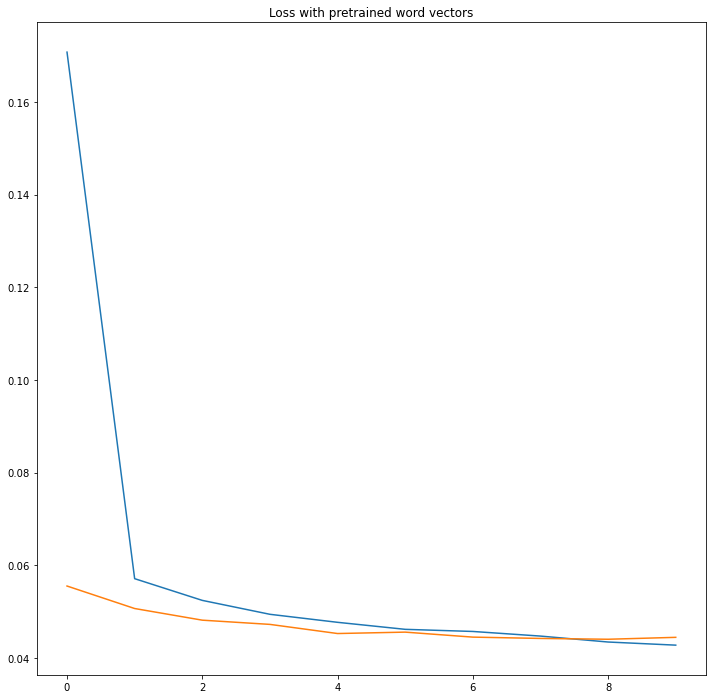

<Figure size 432x288 with 0 Axes>

In [21]:
hist = model.fit([data], y, validation_split=0.1,
                 epochs=10, batch_size=256, shuffle=True)
history = pd.DataFrame(hist.history)
plt.figure(figsize=(12,12))
plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.title("Loss with pretrained word vectors")
plt.show()
file_save = os.path.join(dir_path, 'Data/ToxicComment/plot.png')
plt.savefig(file_save)